In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install polars==1.17.1
!pip install catboost

In [3]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/Utils/")

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import r2_score

import polars as pl

from itertools import combinations
import lightgbm as lgb
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm, Pool

from pathlib import Path
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import gc

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

# from combinatorial_purged_group_kfold import CombinatorialPurgedGroupKFold

DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Jane_Street/data/train.parquet/")

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
feature_09_dict = {
    2: 0,
    4: 1,
    9: 2,
    11: 3,
    12: 4,
    14: 5,
    15: 6,
    25: 7,
    26: 8,
    30: 9,
    34: 10,
    42: 11,
    44: 12,
    46: 13,
    49: 14,
    50: 15,
    57: 16,
    64: 17,
    68: 18,
    70: 19,
    81: 20,
    82: 21
}
feature_10_dict = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 10: 7, 12: 8}
feature_11_dict = {
    9: 0,
    11: 1,
    13: 2,
    16: 3,
    24: 4,
    25: 5,
    34: 6,
    40: 7,
    48: 8,
    50: 9,
    59: 10,
    62: 11,
    63: 12,
    66: 13,
    76: 14,
    150: 15,
    158: 16,
    159: 17,
    171: 18,
    195: 19,
    214: 20,
    230: 21,
    261: 22,
    297: 23,
    336: 24,
    376: 25,
    388: 26,
    410: 27,
    522: 28,
    534: 29,
    539: 30
}

In [5]:
def reduce_memory_usage() -> pl.Expr:
    expressions = [
        pl.col(pl.Float64).cast(pl.Float32),
        pl.col("date_id", "time_id").cast(pl.Int16),
        pl.col("symbol_id").cast(pl.Int8),
        ]
    return expressions

def map_category() -> pl.Expr:
    expressions = [
        pl.col('symbol_id').replace({i: i for i in range(39)}).fill_null(99),
        pl.col('feature_09').replace(feature_09_dict).fill_null(99),
        pl.col('feature_10').replace(feature_10_dict).fill_null(99),
        pl.col('feature_11').replace(feature_11_dict).fill_null(99),
    ]
    return expressions

def get_temporal_features() -> pl.Expr:
    expressions = [
        (pl.col('date_id') % 170).alias('day'),
        (pl.col('date_id') * 2 * np.pi / 170).sin().cast(pl.Float32).alias('date_sin'),
        (pl.col('date_id') * 2 * np.pi / 170).cos().cast(pl.Float32).alias('date_cos'),
        # (pl.col('time_id') * 2 * np.pi / 967).sin().cast(pl.Float32).alias('time_id_sin'),
        # (pl.col('time_id') * 2 * np.pi / 967).cos().cast(pl.Float32).alias('time_id_cos')
    ]
    return expressions

def get_lag_stats_per_day() -> pl.Expr:
    group = ["date_id", "symbol_id"]
    # cols = [f"responder_{i}_lag_1" for i in range(9)]
    cols = ['responder_6_lag_1']
    expressions = []
    for col in cols:
        exprs = [
            # pl.col(col).min().over(group).alias(f"{col}_min"),
            pl.col(col).max().over(group).alias(f"{col}_max"),
            # pl.col(col).std().over(group).alias(f"{col}_std")
            # pl.col(col).median().over(group).alias(f"{col}_median_per_day")
        ]
        expressions.extend(exprs)
    return expressions

def get_lag_features() -> pl.Expr:
    group = ['symbol_id', 'date_id']
    expressions = [
        pl.col('feature_07').shift(2).over(group).alias('feature_07_lag'),
        pl.col('feature_06').shift(1).over(group).alias('feature_06_lag'),
        pl.col('feature_60').shift(2).over(group).alias('feature_60_lag'),
        # pl.col('feature_04').shift(4).over(group).alias('feature_04_lag'),
        # pl.col('feature_05').shift(5).over(group).alias('feature_05_lag'),
        # pl.col('feature_36').shift(4).over(group).alias('feature_36_lag'),
        # pl.col('feature_58').shift(4).over(group).alias('feature_58_lag'),
        # pl.col('feature_59').shift(1).over(group).alias('feature_59_lag'),
        # pl.col('feature_38').shift(8).over(group).alias('feature_38_lag'),
        # pl.col('feature_52').shift(3).over(group).alias('feature_52_lag'),
    ]
    return expressions

def generate_features(df, df_lags):
    exprs_1 = [
        map_category(),
        get_temporal_features(),
        get_lag_features(),
    ]
    expressions = [e for sublist in exprs_1 for e in sublist]
    df = df.with_columns(reduce_memory_usage())
    df = df.with_columns(
        pl.col('feature_09').cast(pl.Int8),
        pl.col('feature_10').cast(pl.Int8),
        pl.col('feature_11').cast(pl.Int16),
    )
    df = df.with_columns(expressions)

    df_lags = df_lags.with_columns(reduce_memory_usage())
    df_lags = df_lags.with_columns(get_lag_stats_per_day())
    df = df.join(
        df_lags,
        on=["date_id", "time_id", "symbol_id"], how="left"
    )
    ign_cols = [f"responder_{i}_lag_1" for i in range(9)] + ['date_id']
    return df.select(pl.all().exclude(ign_cols))

In [6]:
def get_lag_responders() -> pl.Expr:
    cols = [f"responder_{i}" for i in range(9)]
    expressions = [
        pl.col(col)
        .shift(i)
        .over('symbol_id', 'time_id')
        .alias(f"{col}_lag_{i}")
        for col in cols for i in [1] # lags
        ]
    return expressions

train = pl.scan_parquet(DATA_DIR).filter(pl.col('partition_id')>5)
train = train.with_columns(get_lag_responders()).collect()
# remove nulls resulting from day 1 lags
start_date = train.select('date_id')[0]
train = train.filter(pl.col('date_id') > start_date)
train.head()

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32
1021,0,0,2.758212,-0.88871,-0.280876,-0.709766,-1.114013,2.130691,-0.675838,-0.217391,-0.15832,0.157831,11,7,76,-0.824303,1.321677,-0.211726,null,0.028558,null,-1.903073,-1.309708,0.56428,-0.113246,0.460829,0.874078,-0.634349,-0.989553,0.363487,1.548323,0.658012,-0.147794,-0.0248,-0.11404,null,…,0.822857,-0.120644,-0.096939,-0.165281,-1.85763,-1.983462,-0.761288,1.461293,-0.095967,-0.949327,0.945887,-0.22943,null,null,-0.086589,-0.138892,-0.339265,-0.208284,0.143218,0.036284,0.605471,-2.160379,-2.312699,-1.693053,-3.237157,-2.757349,-2.678967,6,0.05749,-0.02038,0.151817,1.176065,-0.683896,1.222135,1.82208,-0.699136,2.865153
1021,0,1,5.128181,-0.667143,-0.156818,-0.551448,-1.022433,1.902604,-0.591912,-0.243567,-0.178642,0.154012,11,7,76,-1.341635,0.35188,-0.521197,null,-0.344777,null,-1.983181,-1.479607,0.43023,0.102232,1.243619,1.429466,-0.268186,-0.352289,0.443074,1.538062,1.902193,-0.358995,-0.486083,0.120412,null,…,0.822857,-0.224284,-0.379963,-0.184559,-1.470559,-1.480629,-0.691343,0.60478,-0.246037,-1.084746,-0.031681,-0.598442,null,null,-0.292409,-0.29329,-0.189932,-0.304927,0.080642,0.031724,0.098682,-0.183446,-0.492214,0.865066,-0.417081,-0.854174,1.2233,6,-0.214946,-0.036094,-0.036046,0.525263,-0.434739,1.235148,0.914796,-0.717382,0.643339
1021,0,2,2.990457,-0.592874,-0.843829,-1.172633,-0.977152,1.665111,-0.780339,-0.248836,-0.295433,0.212535,81,2,59,-0.68717,4.194336,0.333165,null,-0.048717,null,-2.749262,-1.98124,-0.741161,-0.110016,0.762164,0.384524,-1.003869,-0.887358,0.924972,1.867121,1.078736,-0.892071,-0.564501,-0.161899,null,…,0.822857,-0.163303,-0.217823,-0.203042,-1.729299,-1.913308,-0.555369,4.493433,0.638722,-0.765278,2.414558,-0.003537,null,null,0.36877,0.558933,-0.099664,-0.018457,0.105283,0.214745,0.353996,-1.960483,-1.242982,-2.430258,-3.529213,-2.412281,-3.481411,6,-0.441242,-0.281995,0.155182,-1.106123,-0.77156,-0.464858,-0.793521,-0.717857,-1.547887
1021,0,3,1.580349,-0.949817,-0.223031,-0.797525,-0.895173,2.020643,-0.434421,-0.165368,-0.207286,0.163731,4,3,11,-0.966018,1.740896,-0.26865,null,-0.274083,null,-0.462178,-1.663668,-0.468623,-0.010726,-0.718504,-0.659684,0.657763,0.178212,-0.276047,-1.019963,-0.891104,-0.443206,-0.595868,-0.0089,null,…,0.822857,-0.211538,-0.221234,-0.141883,-1.854496,-1.293521,-0.906615,1.082458,-0.1356,-0.96185,1.193984,-0.453,null,null,1.113736,1.278999,0.051255,0.033749,0.078974,0.088442,0.710223,1.622804,2.530923,1.304712,2.790201,2.580255,1.266655,6,0.24601,0.362785,0.000741,0.304133,-0.598776,0.545253,0.198089,-1.289874,0.688991
1021,0,4,3.252043,-0.611066,-0.523858,-0.769166,-1.01305,1.424418,-0.265226,-0.093243,-0.09816,0.076199,15,1,9,-0.771626,4.367999,0.230222,null,-0.341415,null,-1.277562,-1.053409,-0.160347,0.884322,0.977945,-0.11547,2.352565,2.582544,-1.674891,-0.515939,0.555117,-0.733854,-1.190635,0.5816

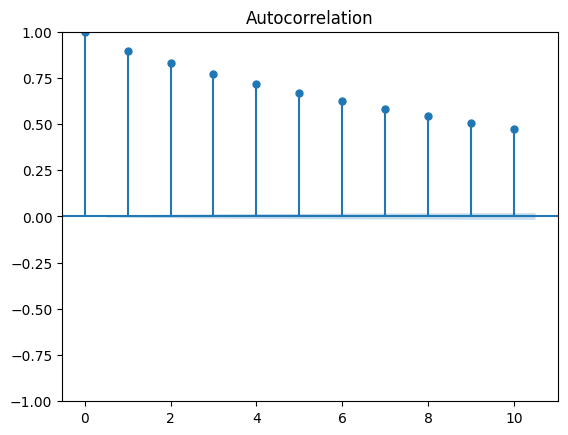

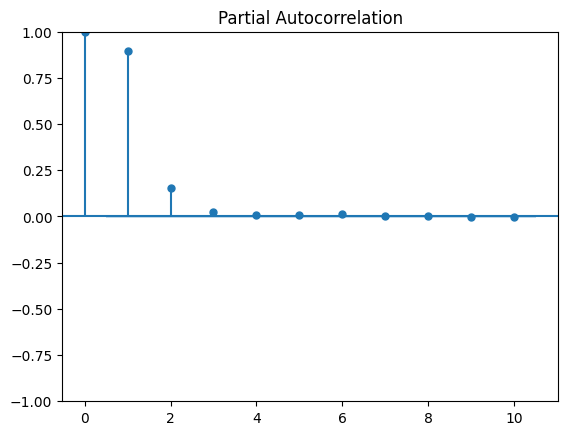

In [7]:
data = train.filter(
    pl.col('date_id')>1576,
    pl.col('symbol_id')==0
    ).select('feature_07').to_numpy().reshape(-1)
plot_acf(data, lags = 10, title='Autocorrelation'); print()
plot_pacf(data, lags = 10, title='Partial Autocorrelation'); print()

In [8]:
features = [f"feature_{i:02}" for i in range(79)]
lag_responders = [f"responder_{i}_lag_1" for i in range(9)]

params = {
    'iterations': 1200,
    'learning_rate': 0.02,
    'depth': 8,
    'l2_leaf_reg': 5,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.9,
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'metric_period': 100,
    'od_type': 'Iter',
    'od_wait': 30,
    'task_type': 'GPU',
    'allow_writing_files': False,
    'use_best_model': False
}

model = CatBoostRegressor(**params)

x_train = generate_features(
    train.filter(pl.col('date_id')<1576).select(['date_id', 'time_id', 'symbol_id', 'weight'] + features),
    train.filter(pl.col('date_id')<1576).select(['date_id', 'time_id', 'symbol_id'] + lag_responders)
    ).to_numpy()
y_train = train.filter(pl.col('date_id')<1576).select('responder_6').to_numpy()

x_valid = generate_features(
    train.filter(pl.col('date_id')>1576).select(['date_id', 'time_id', 'symbol_id', 'weight'] + features),
    train.filter(pl.col('date_id')>1576).select(['date_id', 'time_id', 'symbol_id'] + lag_responders)
    ).to_numpy()
y_valid = train.filter(pl.col('date_id')>1576).select('responder_6').to_numpy()

model.fit(
    Pool(x_train, y_train),
    # verbose=False,
    eval_set=[(x_valid, y_valid)]
)

0:	learn: 0.5512385	test: 0.5399264	best: 0.5399264 (0)	total: 365ms	remaining: 7m 17s
100:	learn: 0.5484951	test: 0.5385427	best: 0.5385427 (100)	total: 26.9s	remaining: 4m 53s
200:	learn: 0.5475404	test: 0.5383450	best: 0.5383450 (200)	total: 53.9s	remaining: 4m 27s
300:	learn: 0.5467941	test: 0.5382276	best: 0.5382276 (300)	total: 1m 22s	remaining: 4m 5s
400:	learn: 0.5461427	test: 0.5381622	best: 0.5381621 (391)	total: 1m 50s	remaining: 3m 39s
500:	learn: 0.5456006	test: 0.5381176	best: 0.5381176 (500)	total: 2m 18s	remaining: 3m 12s
bestTest = 0.538088437
bestIteration = 569


In [9]:
def weighted_r2(y_true, y_pred, sample_weight):
    r2 = (1 - np.average((y_true - y_pred)**2, weights=sample_weight) /
          (np.average(y_true**2, weights=sample_weight) + 1e-38)
    )
    return r2

r2_score = weighted_r2(
    y_valid.reshape(-1),
    model.predict(x_valid),
    train.filter(pl.col('date_id')>1576).select('weight').to_numpy().reshape(-1)
)
print("r2_score:",  r2_score.round(5))

r2_score: 0.00924


In [10]:
del x_train, y_train, x_valid, y_valid

In [11]:
gc.collect()

6805